# Spark imageprocessing

Proces a directory with images

## Import libraries

In [1]:
from typing import Iterator

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType

from PIL import Image, ImageDraw
from tensorflow.keras.applications.resnet50 import ResNet50

import tensorflow as tf
import numpy as np
import pandas as pd

## Start a spark session

In [2]:
spark = SparkSession.builder.appName("LocalResNet").master("local[2]").config("spark.executor.memory", "4G").config("spark.driver.memory", "2G").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/25 12:04:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/25 12:04:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/25 12:04:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/04/25 12:04:06 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


## Read images into a Spark DataFrame

In [3]:
images_dir = "../data/images/mixed/"
image_df = spark.read.format("image").load(images_dir).filter("image.nChannels > 2 AND image.height < 1000")

In [4]:
image_df.select("image.origin", "image.height", "image.width", "image.mode", "image.nChannels").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----+----+---------+
|origin                                                                                                                                                          |height|width|mode|nChannels|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----+----+---------+
|file:///Users/kgeusebroek/dev/godatadriven/projects/gdd-friday/spark-image-processing-blog/sources/spark-image-processing/data/images/mixed/n03394916_31157.JPEG|500   |479  |16  |3        |
|file:///Users/kgeusebroek/dev/godatadriven/projects/gdd-friday/spark-image-processing-blog/sources/spark-image-processing/data/images/mixed/n03394916_6037.JPEG |500   |375  |16  |3        |
|file:///Users/kgeusebroek/dev/godatadriven/p

### Select a single image to show the image preprocessing steps

In [5]:
image_row = 40

In [6]:
spark_single_img = image_df.select("image").collect()[image_row]
(spark_single_img.image.origin, spark_single_img.image.mode, spark_single_img.image.nChannels )

('file:///Users/kgeusebroek/dev/godatadriven/projects/gdd-friday/spark-image-processing-blog/sources/spark-image-processing/data/images/mixed/n03417042_9592.JPEG',
 16,
 3)

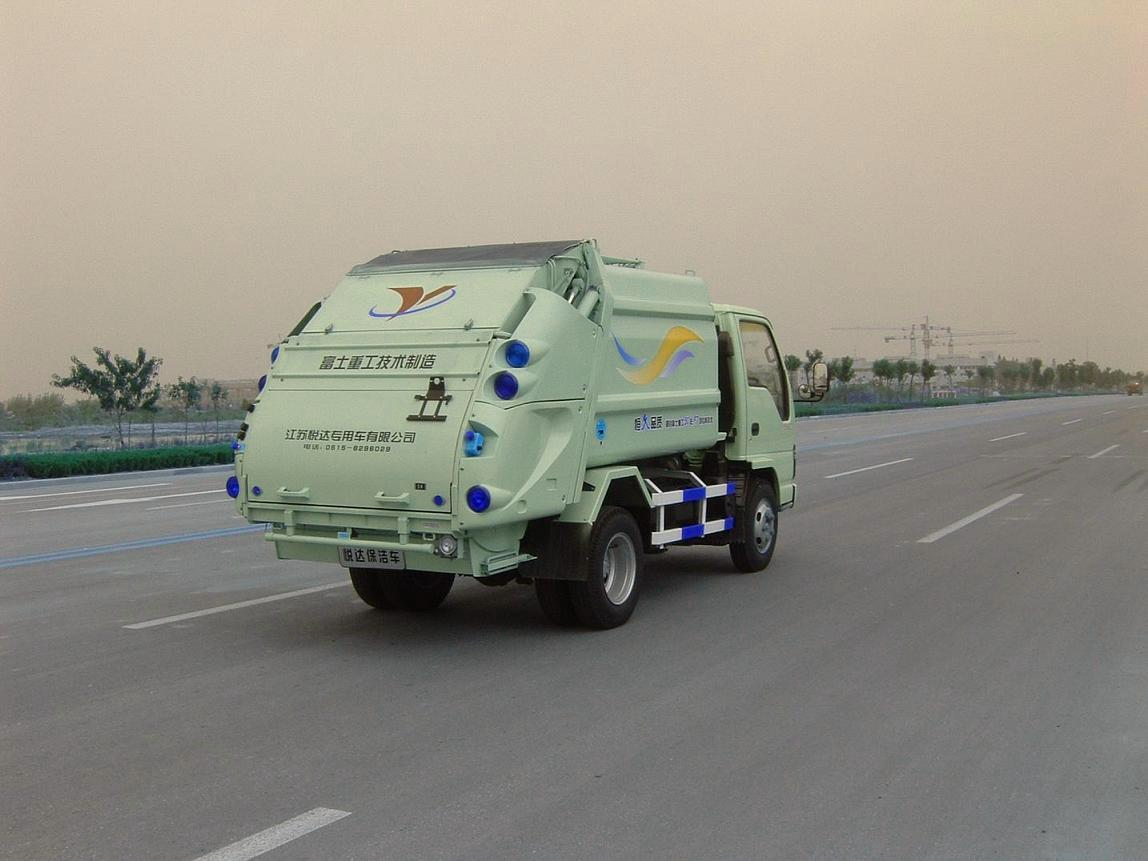

In [7]:
mode = 'RGBA' if (spark_single_img.image.nChannels == 4) else 'RGB' 
Image.frombytes(mode=mode, data=bytes(spark_single_img.image.data), size=[spark_single_img.image.width,spark_single_img.image.height])

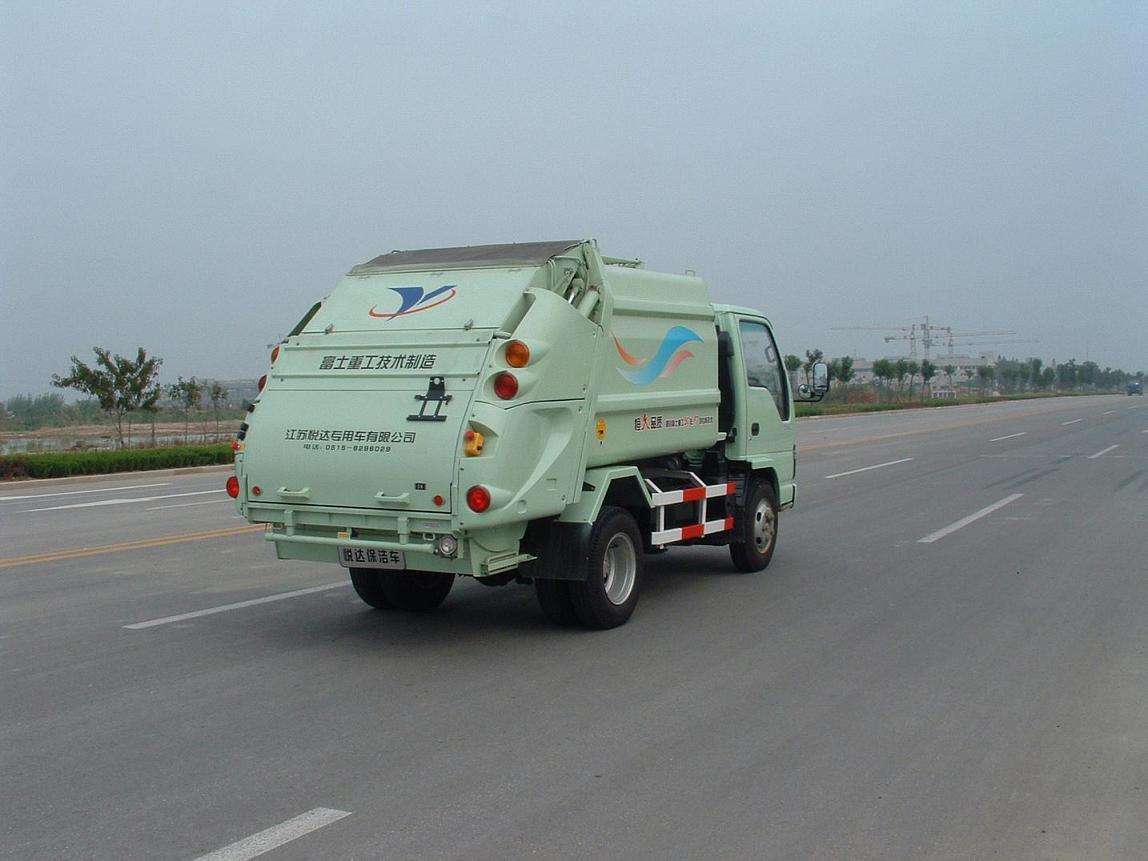

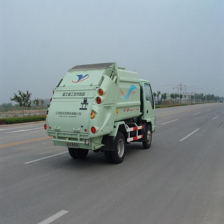

In [8]:
arr = np.frombuffer(spark_single_img.image.data, dtype=np.uint8)
arr_reshaped = arr.reshape([spark_single_img.image.height,spark_single_img.image.width, spark_single_img.image.nChannels])

if (spark_single_img.image.nChannels == 4):
    B, G, R, A = arr_reshaped.T
    rgb_image_array = np.array((R, G, B, A)).T
elif (spark_single_img.image.nChannels == 3):
    B, G, R = arr_reshaped.T
    rgb_image_array = np.array((R, G, B)).T
else:
    rgb_image_array = arr_reshaped

img = Image.fromarray(rgb_image_array)
img_resized = img.resize([224, 224])
arr_resized = np.asarray(img_resized)
img_resized = Image.fromarray(arr_resized)

display(img, img_resized)

## Transform image into resized image with Spark

In [9]:
schema = StructType(image_df.select("image.*").schema.fields + [
    StructField("data_as_resized_array", ArrayType(IntegerType()), True),
    StructField("data_as_array", ArrayType(IntegerType()), True)
])

def convert_bgr_array_to_rgb_array(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T
    
def resize_img(img_data, resize=True):
    mode = 'RGBA' if (img_data.nChannels == 4) else 'RGB' 
    img = Image.frombytes(mode=mode, data=img_data.data, size=[img_data.width, img_data.height])
    img = img.convert('RGB') if (mode == 'RGBA') else img
    img = img.resize([224, 224], resample=Image.Resampling.BICUBIC) if (resize) else img
    arr = convert_bgr_array_to_rgb_array(np.asarray(img))
    arr = arr.reshape([224*224*3]) if (resize) else arr.reshape([img_data.width*img_data.height*3])

    return arr

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in dataframe_batch_iterator:
        dataframe_batch["data_as_resized_array"] = dataframe_batch.apply(resize_img, args=(True,), axis=1)
        dataframe_batch["data_as_array"] = dataframe_batch.apply(resize_img, args=(False,), axis=1)
        yield dataframe_batch

resized_df = image_df.select("image.*").mapInPandas(resize_image_udf, schema)


In [10]:
row = resized_df.collect()[image_row]

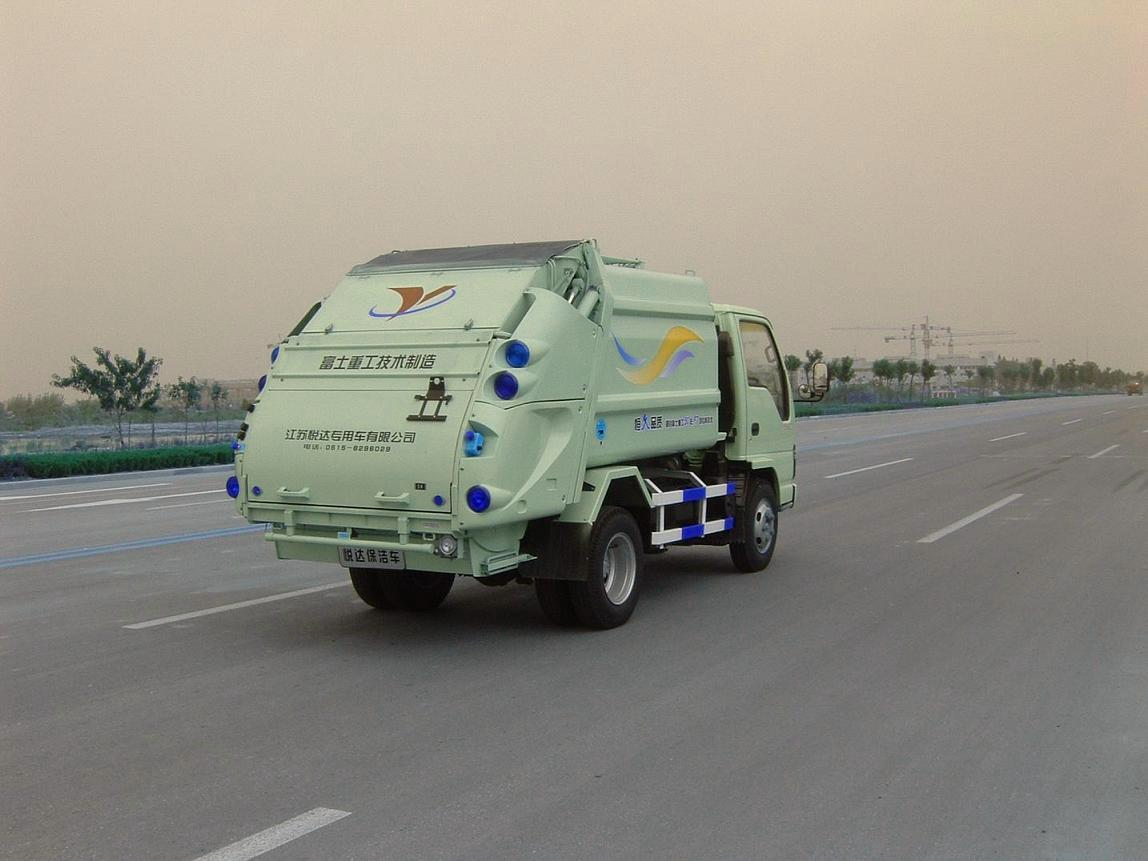

In [11]:
mode = 'RGBA' if (row.nChannels == 4) else 'RGB' 
Image.frombytes(mode=mode, data=bytes(row.data), size=[row.width,row.height])

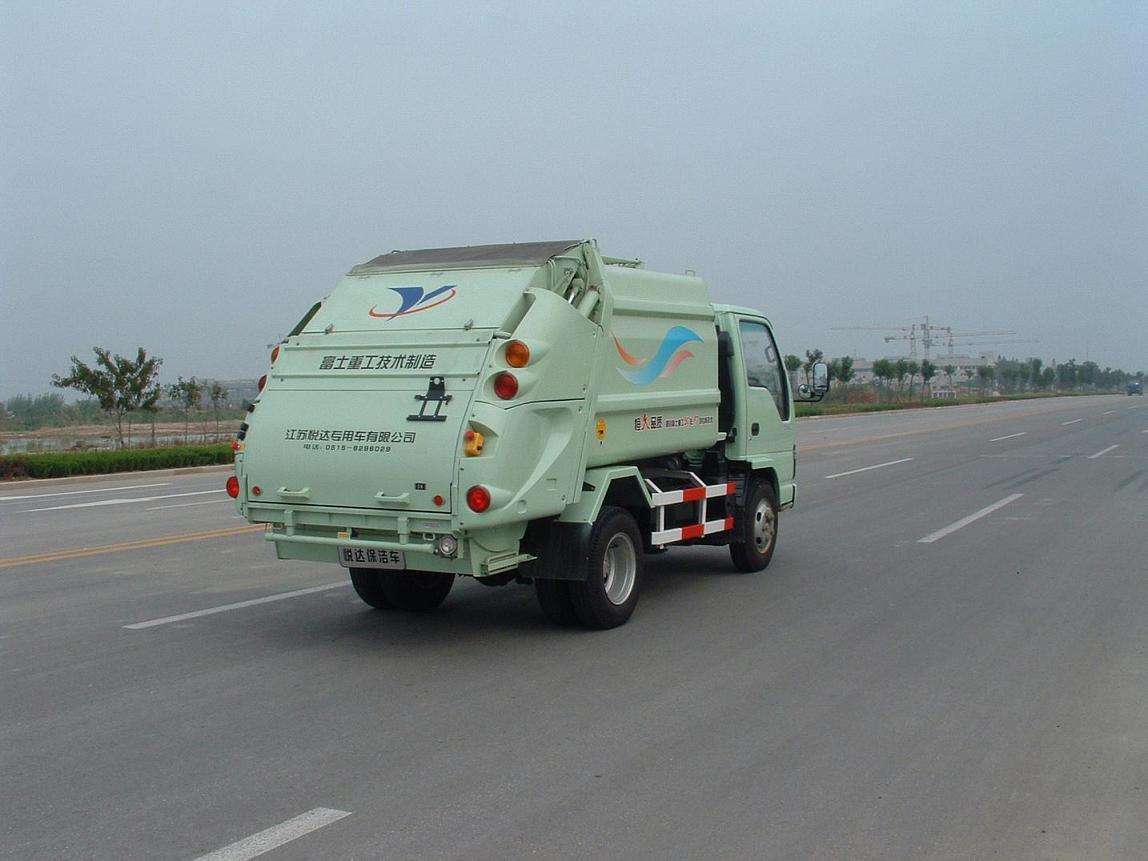

In [12]:
Image.frombytes(mode='RGB', data=bytes(row.data_as_array), size=[row.width,row.height])

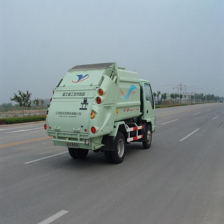

In [13]:
Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224])

## Prediction

In [14]:
def normalize_array(arr):
    return tf.keras.applications.resnet50.preprocess_input(arr.reshape([224,224,3]))

@pandas_udf(ArrayType(FloatType()))
def predict_batch_udf(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = ResNet50()
    for input_array in iterator:
        normalized_input = np.stack(input_array.map(normalize_array))
        preds = model.predict(normalized_input)
        yield pd.Series(list(preds))

In [15]:
predicted_df = resized_df.withColumn("predictions", predict_batch_udf("data_as_resized_array"))

In [16]:
prediction_row = predicted_df.collect()[image_row]

2022-04-25 12:04:38.315104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 12:04:38.315302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 12:04:46.269356: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [17]:
tf.keras.applications.resnet50.decode_predictions(
    np.array(prediction_row.predictions).reshape(1,1000), top=5
)

[[('n03417042', 'garbage_truck', 0.9919044375419617),
  ('n02701002', 'ambulance', 0.004018119070678949),
  ('n03769881', 'minibus', 0.0015384092694148421),
  ('n03770679', 'minivan', 0.0005491302581503987),
  ('n03977966', 'police_van', 0.00048319826601073146)]]

In [18]:
decoded_predictions_schema = StructType(predicted_df.schema.fields + [
    StructField("pred_id", ArrayType(StringType()), False),
    StructField("label", ArrayType(StringType()), False),
    StructField("score", ArrayType(FloatType()), False)
])

def top5_predictions(preds):
    return tf.keras.applications.resnet50.decode_predictions(
        np.array(preds).reshape(1,1000), top=5
    )

def top5predictions_batch_udf(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in iterator:
        yield pd.merge(
            dataframe_batch, 
            right=pd.concat([pd.DataFrame(top5, columns=["pred_id", "label", "score"]).aggregate(lambda x: [x.tolist()], axis=0) for [top5] in dataframe_batch.predictions.map(top5_predictions)]).reset_index(drop=True),
            left_index=True,
            right_index=True
        )

In [19]:
top5_predictions_df = predicted_df.mapInPandas(top5predictions_batch_udf, decoded_predictions_schema)


In [20]:
top5_prediction = top5_predictions_df.collect()[image_row]

2022-04-25 12:05:00.890658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
def image_with_label(image, label):
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), label, fill="red")
    return image


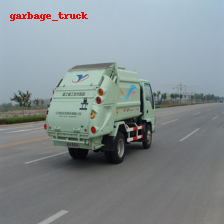

In [22]:
display(image_with_label(
    Image.frombytes(mode='RGB', data=bytes(top5_prediction.data_as_resized_array), size=[224,224]),
    top5_prediction.label[0]
))

2022-04-25 12:07:26.139823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 12:07:26.139930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 12:07:37.442337: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

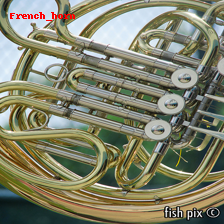

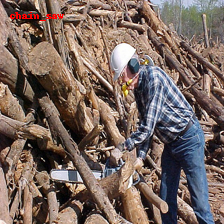

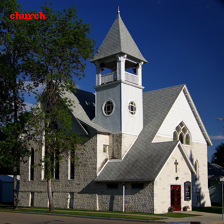

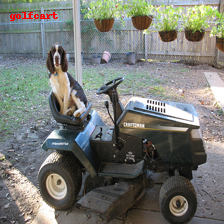

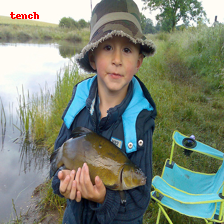

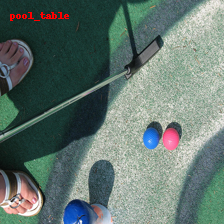

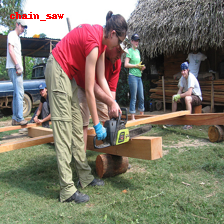

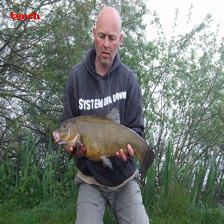

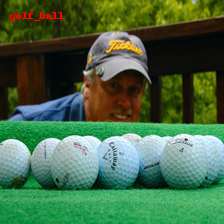

In [24]:
for row in top5_predictions_df.collect()[1:10]:
    display(image_with_label(
        Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224]),
        row.label[0]
    ))